In [1]:
import nltk
import re
import collections
import random
import itertools
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

/home/achang/anaconda3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
with open('../../data/misc/the_last_question.txt', 'rt') as f:
    lines = [l.strip() for l in f]

In [3]:
sents = []
for l in lines:
    sents.extend(nltk.sent_tokenize(l))

In [4]:
counter = collections.Counter()
for s in sents:
    counter.update(s)

In [5]:
id_to_char = ['<NULL>', '<START>', '<END>'] + [c for c, _ in counter.most_common()]
char_to_id = { c: cid for cid, c in enumerate(id_to_char) }

In [6]:
max_len = max(len(s) for s in sents) + 1

In [7]:
random.shuffle(sents)

In [8]:
dev_sents = sents[:40]
train_sents = sents[40:]
len(train_sents), len(dev_sents)

(335, 40)

In [9]:
def convert_sent(s, x, y):
    for i in range(len(s)):
        x[i] = char_to_id[s[i - 1]] if i > 0 else char_to_id['<START>']
        y[i] = char_to_id[s[i]]
    x[len(s)] = char_to_id[s[-1]]
    y[len(s)] = char_to_id['<END>']

def convert_sents(ss):
    max_len =  max(len(s) for s in ss) + 1
    x = np.zeros([len(ss), max_len], np.int64)
    y = np.zeros([len(ss), max_len], np.int64)
    lens = np.zeros([len(ss)], np.int64)
    for i in range(len(ss)):
        convert_sent(ss[i], x[i], y[i])
        lens[i] = len(ss[i]) + 1
    return x, y, lens

In [10]:
xs_dev, ys_dev, ls_dev = convert_sents(dev_sents)
xs_train, ys_train, ls_train = convert_sents(train_sents)

In [11]:
def reset_tf(sess = None, log_device_placement = False):
    if sess:
        sess.close()
    tf.reset_default_graph()
    tf.set_random_seed(0)
    return tf.InteractiveSession()

def dump_statistics():
    total_parameters = 0
    for variable in tf.trainable_variables():
        # shape is an array of tf.Dimension
        shape = variable.get_shape()
        variable_parameters = 1
        for dim in shape:
            variable_parameters *= dim.value
        print('parameters for "%s": %d' % (variable.name, variable_parameters))
        total_parameters += variable_parameters
    print('total parameters: %d' % total_parameters)

In [12]:
sess = None

In [13]:
def rnn_dropout(input_data, rate, training, recurrent = True):
    # sizes
    batch_size = tf.shape(input_data)[0]
    size = input_data.shape[-1].value

    # noise mask
    ns = None
    if recurrent:
        ns = [batch_size, 1, size]

    # apply dropout
    return tf.layers.dropout(input_data, rate = rate, training = training, noise_shape = ns)

def _rnn(input_data, input_hidden, size, dropout_rate, training, recurrent_dropout = True):
    # sizes
    batch_size = tf.shape(input_data)[0]
    input_len = tf.shape(input_data)[1]

    # GRU
    gru = tf.contrib.cudnn_rnn.CudnnGRU(
        num_layers = 1,
        num_units = size,
        input_size = input_data.shape[-1].value)
    
    # variables
    gru_params = tf.get_variable(
        'gru_params',
        [gru.params_size().eval()])
    
    # dropout
    d_in = rnn_dropout(input_data, dropout_rate, training, recurrent_dropout)
    
    # tranpose to time-major
    d_in = tf.transpose(d_in, perm = [1, 0, 2])
    
    # tile input states
    h_in = tf.expand_dims(input_hidden, 0)

    # compute GRU
    d_out, h_out = gru(d_in, h_in, gru_params)
    
    # untranspose from time-major
    d_out = tf.transpose(d_out, perm = [1, 0, 2])
    
    # trim layers axis (always is 1)
    h_out = tf.squeeze(h_out, axis = 0)
    
    return d_out, h_out

def rnn(input_data, input_hidden, size, num_layers, dropout_rate, training, recurrent_dropout = True):
    d_in = input_data
    d_out = []
    h_out = []
    for i in range(num_layers):
        with tf.variable_scope('rnn_%d' % i):
            d, h = _rnn(d_in, input_hidden[i], size, dropout_rate, training, recurrent_dropout)
            d_out.append(d)
            h_out.append(h)
            d_in = d
    return tf.stack(d_out), tf.stack(h_out)

In [14]:
def run(dim = 32, num_layers = 3, dropout_rate = 0.2, dropout_recurrent = True):
    global sess
    
    sess = reset_tf(sess)

    vocab_size = len(id_to_char)

    emb = tf.get_variable('emb', [vocab_size, dim])
    h_init = tf.get_variable('h_init', [num_layers, dim])

    xs = tf.placeholder(tf.int64, [None, None])
    ys = tf.placeholder(tf.int64, [None, None])
    ls = tf.placeholder(tf.int64, [None])
    training = tf.placeholder(tf.bool, [])
    N = tf.shape(xs)[0]

    xs_emb = tf.nn.embedding_lookup(emb, xs)
    ys_emb = tf.nn.embedding_lookup(emb, ys)

    mask = tf.sequence_mask(ls, maxlen = tf.shape(xs)[1], dtype = tf.float32)

    h_in = tf.expand_dims(h_init, 1)
    h_in = tf.tile(h_in, [1, N, 1])

    d_out, h_out = rnn(xs_emb, h_in, dim, num_layers, dropout_rate, training, dropout_recurrent)

    d_out = tf.concat(tf.unstack(d_out), axis = -1)
    d_out = rnn_dropout(d_out, dropout_rate, training, dropout_recurrent)

    logits = tf.layers.dense(d_out, vocab_size)

    ys_prob = tf.nn.softmax(logits)
    ys_est = tf.argmax(ys_prob, axis = -1)

    losses = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = ys, logits = logits)
    losses *= mask
    mean_loss = tf.reduce_sum(losses) / tf.cast(tf.reduce_sum(ls), tf.float32)

    matches = tf.cast(tf.equal(ys_est, ys), tf.float32)
    matches *= mask
    mean_acc = tf.reduce_sum(matches) / tf.cast(tf.reduce_sum(ls), tf.float32)

    lr = tf.placeholder_with_default(tf.constant(1e-3), [])
    optimizer = tf.train.AdamOptimizer(learning_rate = lr)
    gradients, variables = zip(*optimizer.compute_gradients(mean_loss))
    gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
    train_op = optimizer.apply_gradients(zip(gradients, variables))

    #dump_statistics()

    sess.run(tf.global_variables_initializer())

    curr_lr = 1e-3
    patience = 0
    patience_loss = 1e10
    max_patience = 1
    loss_train = 0
    loss_dev = 0
    acc_train = 0
    acc_dev = 0
    tr = tqdm_notebook(range(2000))
    for i in tr:
        sess.run(train_op, feed_dict = { xs: xs_train, ys: ys_train, ls: ls_train, lr: curr_lr, training: True })
        if i % 50 == 0:
            loss_train, acc_train = sess.run([mean_loss, mean_acc], feed_dict = { xs: xs_train, ys: ys_train, ls: ls_train, training: False })
            loss_dev, acc_dev = sess.run([mean_loss, mean_acc], feed_dict = { xs: xs_dev, ys: ys_dev, ls: ls_dev, training: False })
            tr.set_postfix(train_loss = loss_train, train_acc = acc_train, dev_loss = loss_dev, dev_acc = acc_dev, lr = curr_lr)
            if loss_dev < patience_loss:
                patience = 0
                patience_loss = loss_dev
            else:
                patience += 1
            if patience > max_patience:
                curr_lr /= 2
                patience = 0
                patience_loss = loss_dev
                
    return loss_train, loss_dev, acc_train, acc_dev

In [15]:
dims = [16, 32, 64]
num_layers = [3]
dropout_rate = [0, 0.2]
dropout_recurrent = [True, False]

results = {}

for t in itertools.product(dims, num_layers, dropout_rate, dropout_recurrent):
    results[t] = run(*t)

HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))

| dim | # layers | dropout | recurrent | train loss | dev loss | train acc | dev acc |
|---|---|---|---|---|---|---|---|
| 16 | 3 | 0 | False | 1.605356 | 2.0294902 | 0.5277155 | 0.4494184 |
| 16 | 3 | 0 | True | 1.605796 | 2.0296583 | 0.5278052 | 0.44871342 |
| 16 | 3 | 0.2 | False | 1.9435242 | 2.092892 | 0.43290877 | 0.3979556 |
| 16 | 3 | 0.2 | True | 1.9414033 | 2.0937834 | 0.43909767 | 0.40853015 |
| 32 | 3 | 0 | False | 1.2924329 | 1.9977351 | 0.6201453 | 0.47127247 |
| 32 | 3 | 0 | True | 1.2910846 | 1.9989576 | 0.6203247 | 0.4705675 |
| 32 | 3 | 0.2 | False | 1.4973029 | 1.8856517 | 0.5551171 | 0.4751498 |
| 32 | 3 | 0.2 | True | 1.4210378 | 1.8215412 | 0.5735043 | 0.49277407 |
| 64 | 3 | 0 | False | 0.798262 | 2.0995255 | 0.77065206 | 0.4871343 |
| 64 | 3 | 0 | True | 0.8089056 | 2.0918274 | 0.7645529 | 0.48537186 |
| 64 | 3 | 0.2 | False | 0.97265005 | 1.7454623 | 0.6990313 | 0.51850545 |
| 64 | 3 | 0.2 | True | 0.92839587 | 1.7715378 | 0.7123509 | 0.5227353 |

## Recurrent dropout

Params:

```
dim = 64
num_layers = 3
dropout_rate = 0.4
learning_rate = 1e-3
```

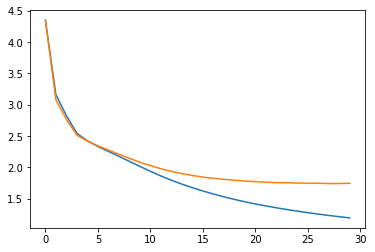

In [260]:
plt.plot(losses_train)
plt.plot(losses_dev)
plt.show()

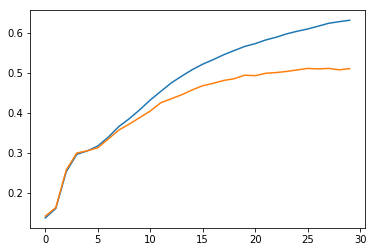

In [261]:
plt.plot(accs_train)
plt.plot(accs_dev)
plt.show()

## Recurrent (0.2)

```
dim = 64
num_layers = 3
vocab_size = len(id_to_char)
dropout_rate = 0.2
dropout_recurrent = True
learning_rate = 1e-3
```

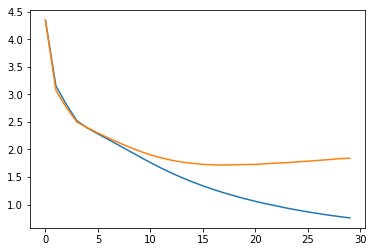

In [278]:
plt.plot(losses_train)
plt.plot(losses_dev)
plt.show()

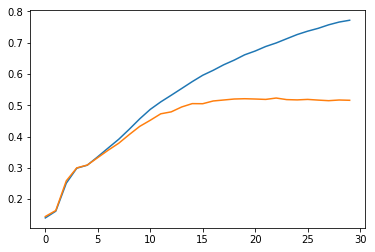

In [279]:
plt.plot(accs_train)
plt.plot(accs_dev)
plt.show()

In [280]:
def sample():
    xs_samp = [[char_to_id['<START>']]]
    ls_samp = [1]
    result = []

    p, h = sess.run([ys_prob, h_out], feed_dict = { xs: xs_samp, ls: ls_samp, training: False })
    p = p[0, 0]
    
    for i in range(500):
        cid = np.random.choice(p.size, p = p)
        if cid == char_to_id['<END>']:
            break
        else:
            result.append(id_to_char[cid])
        xs_samp[0][0] = cid
        p, h = sess.run([ys_prob, h_out], feed_dict = { xs: xs_samp, ls: ls_samp, h_in: h, training: False })
        p = p[0, 0]
        
    return ''.join(result)

In [307]:
sample()

'That said, “THERE IS ANUDEINUFIO I HAVE.”'